Using the brain tumor data included in the ISLP library, complete the following: 

Plot the Kaplan-Meier survival curve with ±1 standard error bands, using the KaplanMeierFitter() estimator in the lifelines package.

Draw a bootstrap sample of size n = 88 from the pairs (yI , i) and compute the resulting Kaplan-Meier survival curve. Repeat this process B = 200 times. Use the results to obtain an estimate of the standard error of the Kaplan-Meier survival curve at each timepoint. Compare this to the standard errors obtained in (a).

Fit a Cox proportional hazards model that uses all of the predictors to predict survival. Summarize the main findings.

Stratify the data by the value of ki. (Since only one observation has ki==40, you can group that observation together with the observations that have ki==60.) Plot Kaplan-Meier survival curves for each of the five strata, adjusted for the other predictors.

In [1]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data
from lifelines import \
     (KaplanMeierFitter,
      CoxPHFitter)
from lifelines.statistics import \
     (logrank_test,
      multivariate_logrank_test)
from ISLP.survival import sim_time




C:\Users\ekim298\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Import brain tumor data in the ISLP library
BrainCancer = load_data('BrainCancer')
BrainCancer.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

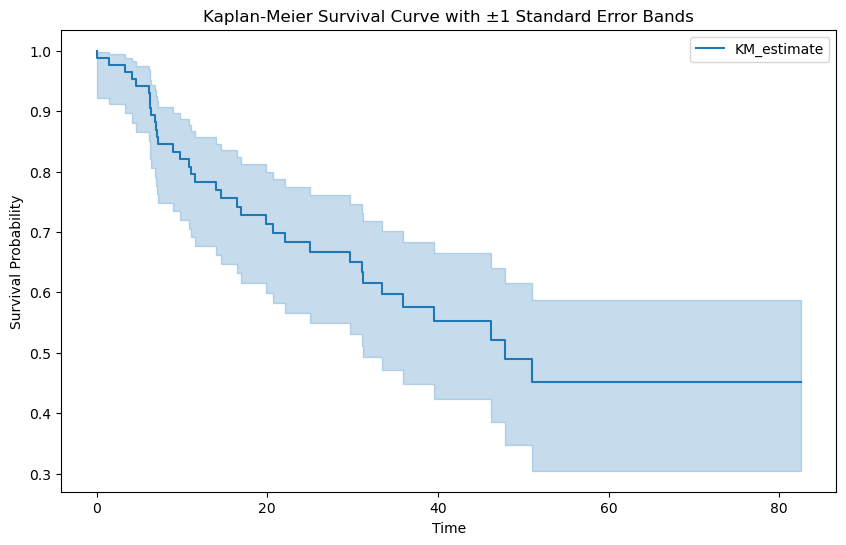

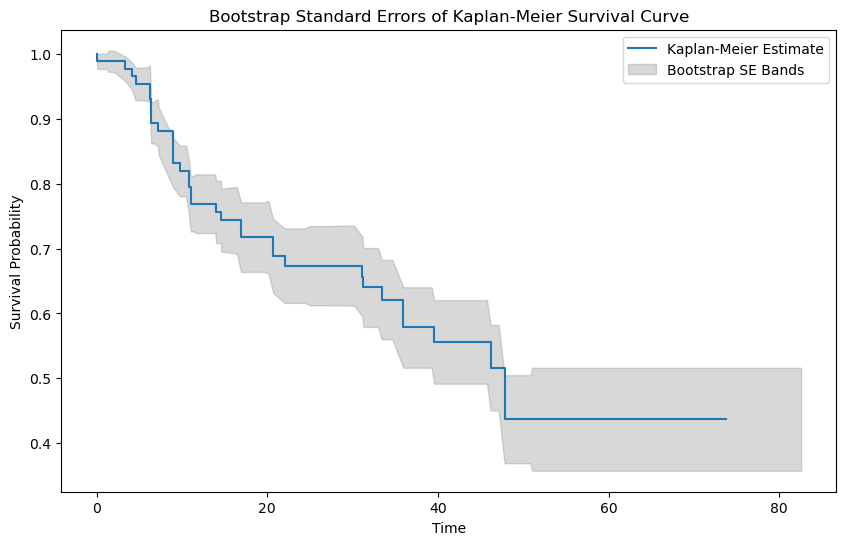

In [3]:
import matplotlib.pyplot as plt
# Task (a): Plot Kaplan-Meier survival curve with ±1 standard error
kmf = KaplanMeierFitter()
kmf.fit(durations=BrainCancer['time'], event_observed=BrainCancer['status'])

plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan-Meier Survival Curve with ±1 Standard Error Bands")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

# Task (b): Bootstrap to estimate standard error
n = len(BrainCancer)
B = 200  # Number of bootstrap samples
bootstrap_survival_curves = []
# Unique time points from the original data
time_points = kmf.survival_function_.index

bootstrap_survival_curves = []

for _ in range(B):
    sample = BrainCancer.sample(n=n, replace=True)
    kmf.fit(durations=sample['time'], event_observed=sample['status'])
    # Reindex to align all curves to the common time points
    bootstrap_survival_curves.append(kmf.predict(time_points).values)

bootstrap_survival_curves = np.array(bootstrap_survival_curves)
bootstrap_se = np.std(bootstrap_survival_curves, axis=0)

# Plot the bootstrap SE alongside the KM curve SE
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=False, label="Kaplan-Meier Estimate")
plt.fill_between(
    time_points,
    kmf.predict(time_points) - bootstrap_se,
    kmf.predict(time_points) + bootstrap_se,
    color="gray",
    alpha=0.3,
    label="Bootstrap SE Bands"
)
plt.title("Bootstrap Standard Errors of Kaplan-Meier Survival Curve")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()


Overall, the bootstrapped standard errors are smaller.

In [ ]:
# (c)
# Re-call data
BrainCancer = load_data('BrainCancer')
# BrainCancer.columns
# Fit Cox PH model
coxph = CoxPHFitter()
cleaned = BrainCancer.dropna()
all_MS = MS(cleaned.columns, intercept=False)
all_df = all_MS.fit_transform(cleaned)
fit_all = coxph.fit(all_df,
                      'time',
                      'status')
fit_all.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
sex[Male],0.183748,0.360358,0.610119
diagnosis[LG glioma],-1.239530,0.579555,0.032455
diagnosis[Meningioma],-2.154566,0.450524,0.000002
diagnosis[Other],-1.268870,0.617672,0.039949
loc[Supratentorial],0.441195,0.703669,0.530665
ki,-0.054955,0.018314,0.002693
gtv,0.034293,0.022333,0.124661
stereo[SRT],0.177778,0.601578,0.767597


In [15]:
# Group ki == 40 into ki == 60
cleaned['ki'] = cleaned['ki'].replace(40, 60)
levels = cleaned['ki'].unique()
def representative(series):
    if hasattr(series.dtype, 'categories'):
        return pd.Series.mode(series)
    else:
        return series.mean()
modal_data = cleaned.apply(representative, axis=0)

C:\Users\ekim298\AppData\Local\Temp\ipykernel_18044\900064202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['ki'] = cleaned['ki'].replace(40, 60)


In [16]:
modal_df = pd.DataFrame(
              [modal_data.iloc[0] for _ in range(len(levels))])
modal_df['ki'] = levels
modal_df

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Supratentorial,90,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,70,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,80,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,100,8.687011,SRT,0.402299,27.188621
0,Female,Meningioma,Supratentorial,60,8.687011,SRT,0.402299,27.188621


In [17]:
modal_X = all_MS.transform(modal_df)
modal_X.index = levels
modal_X


,sex[Male],diagnosis[LG glioma],diagnosis[Meningioma],diagnosis[Other],loc[Supratentorial],ki,gtv,stereo[SRT],status,time
90,0.0,0.0,1.0,0.0,1.0,90,8.687011,1.0,0.402299,27.188621
70,0.0,0.0,1.0,0.0,1.0,70,8.687011,1.0,0.402299,27.188621
80,0.0,0.0,1.0,0.0,1.0,80,8.687011,1.0,0.402299,27.188621
100,0.0,0.0,1.0,0.0,1.0,100,8.687011,1.0,0.402299,27.188621
60,0.0,0.0,1.0,0.0,1.0,60,8.687011,1.0,0.402299,27.188621


In [18]:
predicted_survival = fit_all.predict_survival_function(modal_X)
predicted_survival

,90,70,80,100,60
0.07,0.998753,0.996261,0.997840,0.999280,0.993532
1.18,0.998753,0.996261,0.997840,0.999280,0.993532
1.41,0.997374,0.992140,0.995455,0.998484,0.986421
1.54,0.997374,0.992140,0.995455,0.998484,0.986421
2.03,0.997374,0.992140,0.995455,0.998484,0.986421
...,...,...,...,...,...
65.02,0.797428,0.506907,0.675589,0.877517,0.308173
67.38,0.797428,0.506907,0.675589,0.877517,0.308173
73.74,0.797428,0.506907,0.675589,0.877517,0.308173
78.75,0.797428,0.506907,0.675589,0.877517,0.308173


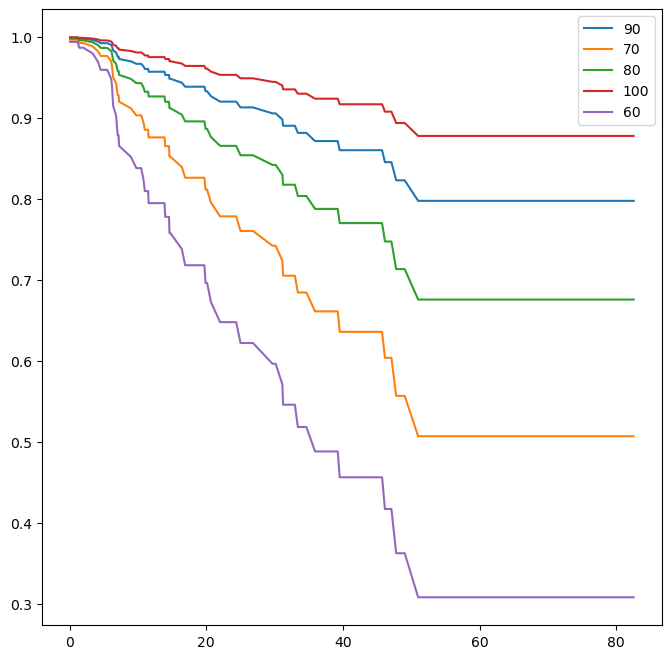

In [19]:
fig, ax = subplots(figsize=(8, 8))
predicted_survival.plot(ax=ax);